# Credmark Workshop for MetricsDAO

- 2023.6.20
- Join Credmark Discord: https://credmark.com/contact-us

1. Token (symbol, name, )
2. Contract (Uniswap V2)
3. Get the reserve, get the price
4. Get the reserve for the past
5. Get the reserve for a range of time.


## Initialize


In [1]:
from credmark.cmf.ipython import create_cmf
from credmark.cmf.types import Token, Contract, Address, BlockNumber

context, model_loader = create_cmf(show_params=True)

Credmark context created with 
- chain_id=1
- block_number=None
- chain_provider_url=http://192...8545
- model_loader_path=['/home/yangye/dev/credmark/credmark-models-py/models']
- api_url=https://gateway.credmark.com
- use_local_models=None



In [2]:
# print the chain ID, block number and block timestamp
print((context.chain_id, context.block_number, context.block_number.timestamp_datetime.isoformat()))

(1, 17478546, '2023-06-14T13:42:35+00:00')


## 1. Token


In [3]:
# WBTC token
wbtc = Token('0x2260fac5e5542a773aa44fbcfedf7c193bc2c599')
print((wbtc.symbol, wbtc.total_supply, wbtc.decimals))

# These values shall match closely with what's shown in
# https://etherscan.io/address/0x2260fac5e5542a773aa44fbcfedf7c193bc2c599#readContract
# We have shown as live, while EtherScan update some time ago.

('WBTC', 15674767544250, 8)


## 2. Contract

- We choose an exchange pool from Uniswap V2
- https://v2.info.uniswap.org/home
- V2 pool is simple because the ratio between two tokens' reserves is the price.

For example:

- The USDC-ETH pool is composed of two tokens: USDC and ETH.
- The pool's reserves are the total amount of USDC and ETH in the pool.
- ETH's price in USDC is USDC's reserve divided by ETH's reserve.


In [4]:
eth_usdc_pool = Contract('0xB4e16d0168e52d35CaCD2c6185b44281Ec28C9Dc')

# Explore the pool contract
display(dir(eth_usdc_pool.abi.functions))

# The detail of token0/token1/getReserves function
print(eth_usdc_pool.abi.functions.token0)
print('---')
print(eth_usdc_pool.abi.functions.token1)
print('---')
print(eth_usdc_pool.abi.functions.getReserves)

['DOMAIN_SEPARATOR',
 'MINIMUM_LIQUIDITY',
 'PERMIT_TYPEHASH',
 'allowance',
 'approve',
 'balanceOf',
 'burn',
 'decimals',
 'factory',
 'getReserves',
 'initialize',
 'kLast',
 'mint',
 'name',
 'nonces',
 'permit',
 'price0CumulativeLast',
 'price1CumulativeLast',
 'skim',
 'swap',
 'symbol',
 'sync',
 'token0',
 'token1',
 'totalSupply',
 'transfer',
 'transferFrom']

Function Name: token0
Args: []
Types: []
Output: ['address']
---
Function Name: token1
Args: []
Types: []
Output: ['address']
---
Function Name: getReserves
Args: []
Types: []
Output: ['uint112', 'uint112', 'uint32']


In [5]:
token0_addr = eth_usdc_pool.functions.token0().call()
token1_addr = eth_usdc_pool.functions.token1().call()

# The addresses of two tokens
print((token0_addr, token1_addr))

# Know what these tokens are actually are
token0 = Token(token0_addr)
token1 = Token(token1_addr)
print((token0.symbol, token1.symbol))

('0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48', '0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2')
('USDC', 'WETH')


In [6]:
# Get the reserve of two tokens in this pool
reserve = eth_usdc_pool.functions.getReserves().call()
print((reserve))

# split the return tuple to three values
_reserve0, _reserve1, _block_timestamp_last = reserve

# price of ETH (as token1) = reserve0 / reserve1, scaled by each token's decimals
price_eth = token0.scaled(_reserve0) / token1.scaled(_reserve1)

print(price_eth)

[26748351880127, 15333072346002775665800, 1686750131]
1744.4874240810657


## 3. Write a model


In [7]:
from credmark.cmf.model import Model


@Model.describe(
    slug='jit.uniswap-v2-reserve',
    version='1.1',
    input=Contract,
    output=dict)
class UniswapV2Reserve(Model):
    def run(self, input):
        token0_addr = input.functions.token0().call()
        token1_addr = input.functions.token1().call()
        _reserve0, _reserve1, _block_timestamp_last = input.functions.getReserves().call()
        price_token1 = token0.scaled(_reserve0) / token1.scaled(_reserve1)
        return {'price_token1': price_token1,
                'price_token0': 1 / price_token1,
                'reserve0': _reserve0,
                'reserve1': _reserve1}

# We can save this as a file in the models/ directory.


# Here we directly load it from the definition and it can only be used in this notebook.
context.add_model(UniswapV2Reserve)

In [8]:
context.run_model('jit.uniswap-v2-reserve',
                  {'address': '0xB4e16d0168e52d35CaCD2c6185b44281Ec28C9Dc'})

{'price_token1': 1744.4874240810657,
 'price_token0': 0.0005732342842922841,
 'reserve0': 26748351880127,
 'reserve1': 15333072346002775665800}

In [9]:
# We can run model on earlier block

earlier_block = context.block_number - 1_000_000

display(earlier_block.timestamp_datetime)

context.run_model('jit.uniswap-v2-reserve',
                  {'address': '0xB4e16d0168e52d35CaCD2c6185b44281Ec28C9Dc'},
                  block_number=earlier_block)

datetime.datetime(2023, 1, 24, 18, 45, 35, tzinfo=datetime.timezone.utc)

{'price_token1': 1619.330188361079,
 'price_token0': 0.0006175392808628474,
 'reserve0': 50161578904736,
 'reserve1': 30976745363775645653333}

## 4. Scale up the model for more blocks


In [10]:
# Run the model for 1000 blocks will take a while, how could we speed up?

for offset in range(10):
    context.run_model('jit.uniswap-v2-reserve',
                      {'address': '0xB4e16d0168e52d35CaCD2c6185b44281Ec28C9Dc'},
                      block_number=context.block_number - offset)

In [11]:
# Uniswap V2 pool's reserve changes with Mint/Burn/Swap, it kept a record of these events.
# Event Sync occurs together with Mint/Burn to record the reserve, that's we need.
# Let's query that event log for Sync.

with eth_usdc_pool.ledger.events.Sync as q:
    df = q.select(q.columns,
                  where=q.BLOCK_NUMBER.ge(context.block_number-2000),
                  order_by=q.BLOCK_NUMBER.comma_(q.LOG_INDEX)).to_dataframe()

# Note: because we limit each query to return 5000 results, when returned the results <= 5000 rows.
# We need to query multiple times to get all the results.

df

# Query this data only takes less than a second.

,block_number,block_timestamp,contract_address,log_index,signature,transaction_hash,evt_reserve0,evt_reserve1
0,17476552,2023-06-14T06:57:59.000Z,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,170,"Sync(uint112,uint112)",0x0d169e10b41c67a6fdeaec7b30fc94cf0014e9f62510...,26827950821187,15394917031562250532970
1,17476567,2023-06-14T07:00:59.000Z,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,197,"Sync(uint112,uint112)",0x8a31e58a6b59ed0aaa6154658e67875fafe9ed5d5dac...,26827471677162,15395192815219646601596
2,17476571,2023-06-14T07:01:47.000Z,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,125,"Sync(uint112,uint112)",0xda5ad8f69f8e54731664c99f07d3b0f237e9f785d525...,26827337349518,15395270132719646601596
3,17476574,2023-06-14T07:02:23.000Z,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,72,"Sync(uint112,uint112)",0x24c1ba2bf97ee5f455202fb0914577eca01324a38f6f...,26827337349518,15395270132719646601596
4,17476587,2023-06-14T07:04:59.000Z,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,174,"Sync(uint112,uint112)",0x0fd3b47418d546d07c8a41dec64240b39a460327e5bb...,26827285685399,15395299870219646601596
...,...,...,...,...,...,...,...,...
227,17478490,2023-06-14T13:31:11.000Z,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,179,"Sync(uint112,uint112)",0xed7d86473154e7a1d4f75190bdfc971ee2c9f9f22610...,26850150411945,15381790908202654417986
228,17478494,2023-06-14T13:31:59.000Z,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,141,"Sync(uint112,uint112)",0x245f10603219907ffec68769116022b85e2729e160f8...,26849808817483,15381987190606868248332
229,17478502,2023-06-14T13:33:35.000Z,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,28,"Sync(uint112,uint112)",0xd77a8c41a6c52311cec01fdf140098e782ef0c15ab00...,26842135373053,15386397718541815434987
230,17478511,2023-06-14T13:35:23.000Z,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,193,"Sync(uint112,uint112)",0x94656c8de37d14b70569a4c05844c6da84371d30203a...,26748727521990,15332854648047482168584


,block_number,reserve0,reserve1
0,17476552,26827950821187,15394917031562250532970
1,17476567,26827471677162,15395192815219646601596
2,17476571,26827337349518,15395270132719646601596
3,17476574,26827337349518,15395270132719646601596
4,17476587,26827285685399,15395299870219646601596
...,...,...,...
227,17478490,26850150411945,15381790908202654417986
228,17478494,26849808817483,15381987190606868248332
229,17478502,26842135373053,15386397718541815434987
230,17478511,26748727521990,15332854648047482168584


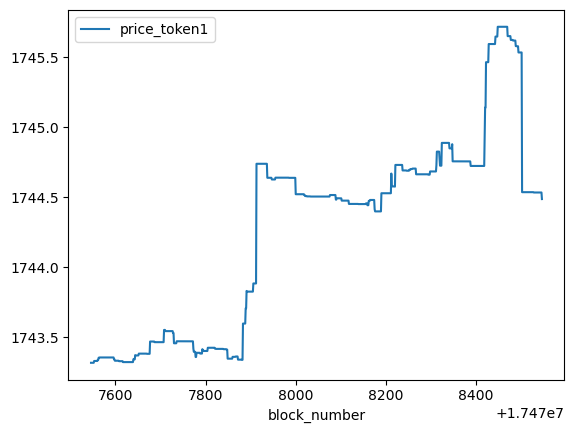

In [12]:
df_clean = (df
            .drop_duplicates(subset=['block_number'], keep='last')
            .loc[:, ['block_number', 'evt_reserve0', 'evt_reserve1']]
            .rename(columns={'evt_reserve0': 'reserve0', 'evt_reserve1': 'reserve1'})
            .assign(block_number=lambda x: x.block_number.astype(int),
                    reserve0=lambda x: x.reserve0.apply(int),
                    reserve1=lambda x: x.reserve1.apply(int),))
display(df_clean)

current_reserve = context.run_model('jit.uniswap-v2-reserve',
                                    {'address': '0xB4e16d0168e52d35CaCD2c6185b44281Ec28C9Dc'})

if df_clean.empty or df_clean.loc[df_clean.shape[0]-1, 'block_number'] != context.block_number:
    df_clean = pd.concat([
        df_clean,
        pd.DataFrame({'block_number': [context.block_number],
                      'reserve0': [current_reserve['reserve0']],
                      'reserve1': [current_reserve['reserve1']]})]).reset_index(drop=True)

df_clean['price_token1'] = token0.scaled(df_clean['reserve0']) / token1.scaled(df_clean['reserve1'])
df_clean['price_token0'] = 1 / df_clean['price_token1']

df_clean = (df_clean
            .merge(pd.DataFrame({'block_number': range(context.block_number-1000, context.block_number+1)}), how='right')
            .sort_values('block_number')
            .fillna(method='ffill')
            .fillna(method='bfill')
            .plot('block_number', 'price_token1'))

## 5. A more complete version in the form of a model for Uniswap V2 price for a range


In [13]:
# Let's create a model for a range of block numbers
# It support cases when there are > 5000 Sync events in the range, or no event during the

from credmark.cmf.types import Records
from credmark.dto import DTOField
import pandas as pd


class ContractWithRange(Contract):
    block_range: int = DTOField(ge=0, description='Block range to query')


@Model.describe(
    slug='jit.uniswap-v2-reserve-range',
    version='1.1',
    input=ContractWithRange,
    output=Records)
class UniswapV2ReserveRange(Model):
    def run(self, input):
        current_reserve = self.context.run_model('jit.uniswap-v2-reserve',
                                                 input)

        dfs = []
        with input.ledger.events.Sync as q:
            while True:
                df = q.select(q.columns,
                              where=q.BLOCK_NUMBER.ge(context.block_number-input.block_range),
                              order_by=q.BLOCK_NUMBER.comma_(q.LOG_INDEX)).to_dataframe()

                if not df.empty:
                    dfs.append(df)

                if df.shape[0] < 5000:
                    break

        if len(dfs) == 0:
            return Records.from_dataframe(pd.DataFrame({
                'block_number': range(context.block_number-input.block_range, context.block_number),
                'price_token1': current_reserve['price_token1'],
                'price_token0': current_reserve['price_token1'],
                'reserve0': current_reserve['reserve0'],
                'reserve1': current_reserve['reserve1'],
            }))
        else:
            df_clean = (pd.concat(dfs)
                        .drop_duplicates(subset=['block_number'], keep='last')
                        .loc[:, ['block_number', 'evt_reserve0', 'evt_reserve1']]
                        .rename(columns={'evt_reserve0': 'reserve0', 'evt_reserve1': 'reserve1'})
                        .assign(block_number=lambda x: x.block_number.astype(int),
                                reserve0=lambda x: x.reserve0.apply(int),
                                reserve1=lambda x: x.reserve1.apply(int),))

            if df_clean.loc[df_clean.shape[0]-1, 'block_number'] != context.block_number:
                df_clean = pd.concat([
                    df_clean,
                    pd.DataFrame({'block_number': [context.block_number],
                                  'reserve0': [current_reserve['reserve0']],
                                  'reserve1': [current_reserve['reserve1']]})])

            df_clean['price_token1'] = token0.scaled(df_clean['reserve0']) / token1.scaled(df_clean['reserve1'])
            df_clean['price_token0'] = 1 / df_clean['price_token1']

            df_clean = (df_clean
                        .merge(pd.DataFrame({'block_number': range(context.block_number-1000, context.block_number+1)}), how='right')
                        .sort_values('block_number')
                        .fillna(method='ffill')
                        .fillna(method='bfill'))

        return Records.from_dataframe(df_clean)


context.add_model(UniswapV2ReserveRange)

<Axes: xlabel='block_number'>

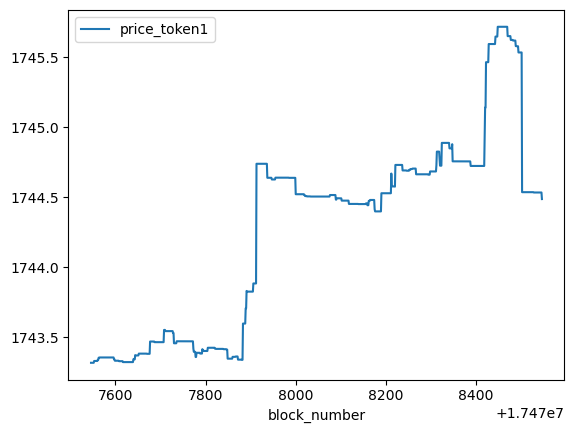

In [14]:
context.reset_cache()
df_range = context.run_model('jit.uniswap-v2-reserve-range',
                             {'address': '0xB4e16d0168e52d35CaCD2c6185b44281Ec28C9Dc', 'block_range': 1000},
                             return_type=Records).to_dataframe()

df_range.plot('block_number', 'price_token1')